In [0]:
!rm -rf ./Texture-segmentation/

In [1]:
!git clone https://github.com/Het-Shah/Texture-segmentation.git

Cloning into 'Texture-segmentation'...
remote: Enumerating objects: 6892, done.
remote: Counting objects: 100% (6892/6892), done.
remote: Compressing objects: 100% (6756/6756), done.
remote: Total 6892 (delta 138), reused 6884 (delta 135), pack-reused 0
Receiving objects: 100% (6892/6892), 128.44 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Checking out files: 100% (8190/8190), done.


In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from PIL import Image

Using TensorFlow backend.


In [3]:
ids = next(os.walk('./Texture-segmentation/data'))[2]
print(len(ids))

2376


In [0]:
im_height = 256
im_width = 256
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [5]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images16
    img = load_img("./Texture-segmentation/data/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("./Texture-segmentation/masks/"+'mask_'+id_, grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x) 
    
    return x


In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""

    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])


W0708 15:18:02.362644 140106537371520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 15:18:02.365876 140106537371520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0708 15:18:02.407264 140106537371520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 15:18:02.409498 140106537371520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0708 15:18:05.677034

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 256, 256, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    ModelCheckpoint('model-tgs-texture.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
results = model.fit(X, y, batch_size=32, epochs=50, callbacks=callbacks,validation_data=(X_valid,y_valid))

Train on 2376 samples, validate on 238 samples
Epoch 1/50
2376/2376 [==============================] - 43s 18ms/step - loss: 0.0330 - acc: 0.9546 - val_loss: 0.0277 - val_acc: 0.9563

Epoch 00001: val_loss improved from inf to 0.02767, saving model to model-tgs-texture.h5
Epoch 2/50
2376/2376 [==============================] - 42s 18ms/step - loss: 0.0299 - acc: 0.9555 - val_loss: 0.0296 - val_acc: 0.9552

Epoch 00002: val_loss did not improve from 0.02767
Epoch 3/50
2376/2376 [==============================] - 42s 18ms/step - loss: 0.0362 - acc: 0.9537 - val_loss: 0.1390 - val_acc: 0.9183

Epoch 00003: val_loss did not improve from 0.02767
Epoch 4/50
2376/2376 [==============================] - 42s 18ms/step - loss: 0.0299 - acc: 0.9555 - val_loss: 0.0264 - val_acc: 0.9564

Epoch 00004: val_loss improved from 0.02767 to 0.02640, saving model to model-tgs-texture.h5
Epoch 5/50
2376/2376 [==============================] - 42s 18ms/step - loss: 0.0377 - acc: 0.9532 - val_loss: 0.0429 - v

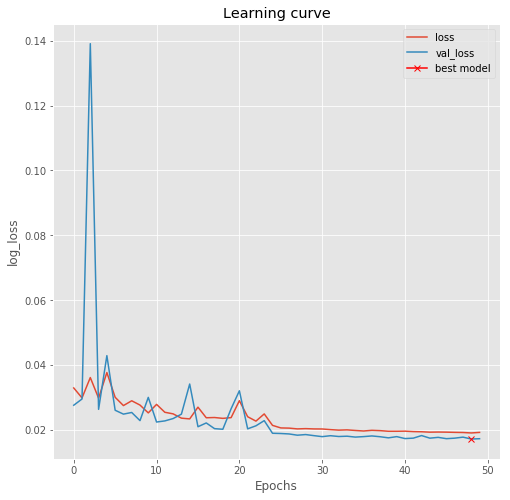

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
model.load_weights('./model-tgs-texture.h5')

In [0]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

238/238 [==============================] - 1s 5ms/step


[0.017257059673864802, 0.9579631916615141]

In [0]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

238/238 [==============================] - 1s 5ms/step


In [0]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), levels=[0.5])
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), levels=[0.5])
    ax[3].set_title('Mask Predicted binary');

# Inference

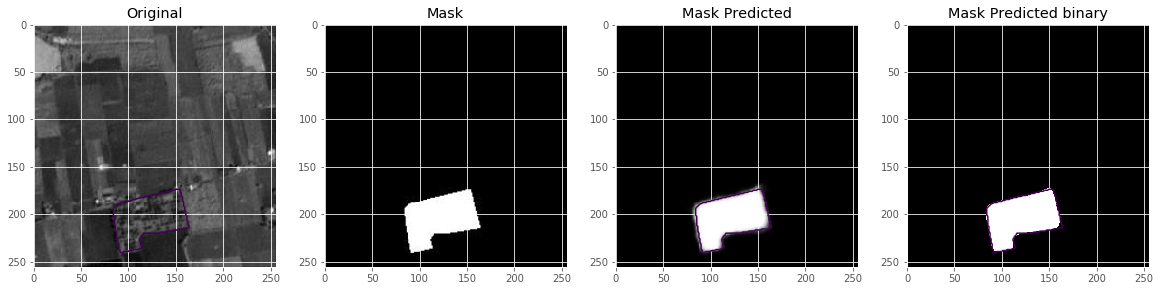

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

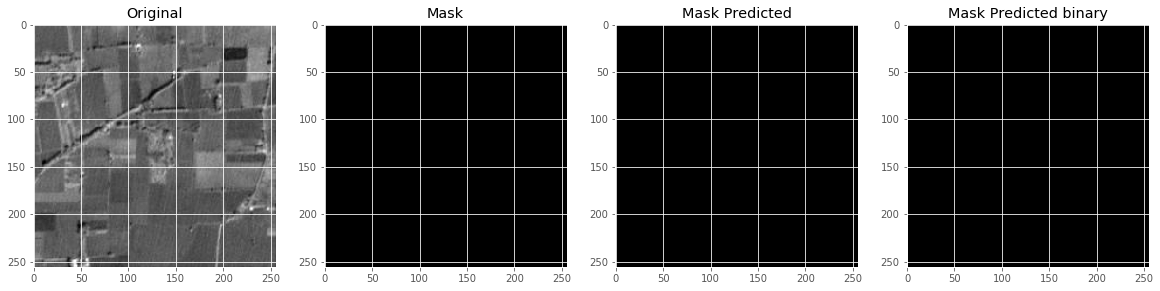

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

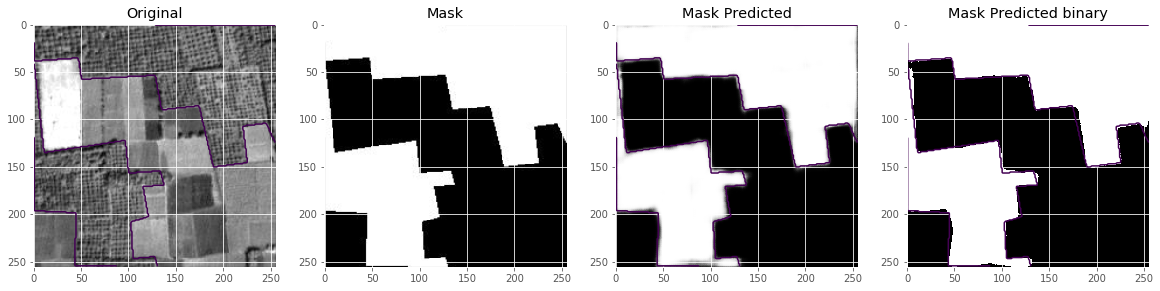

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

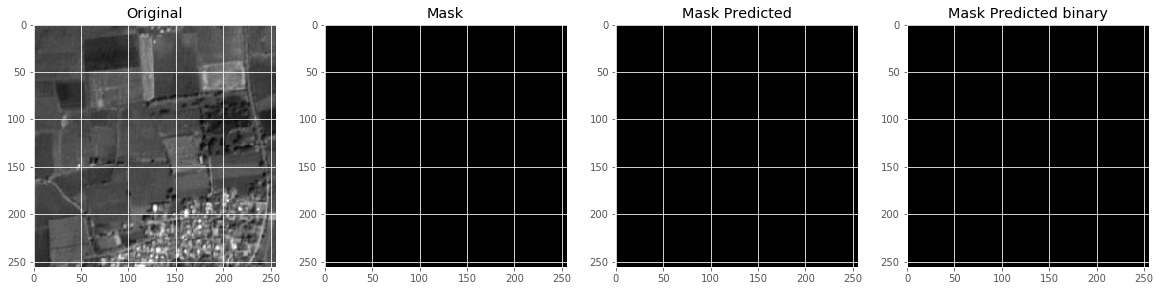

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

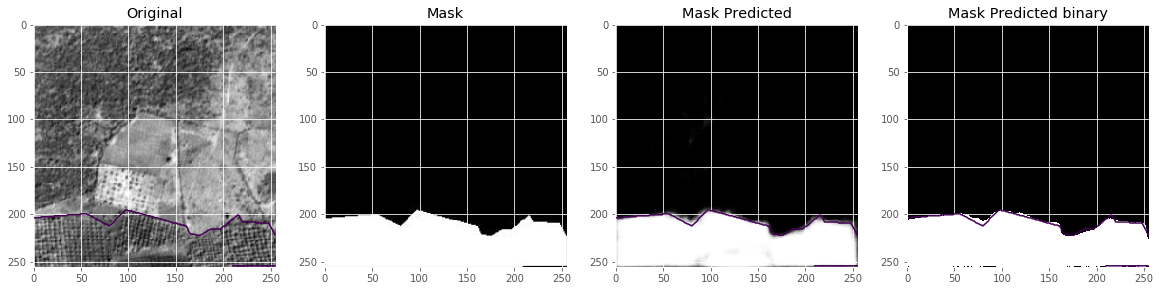

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

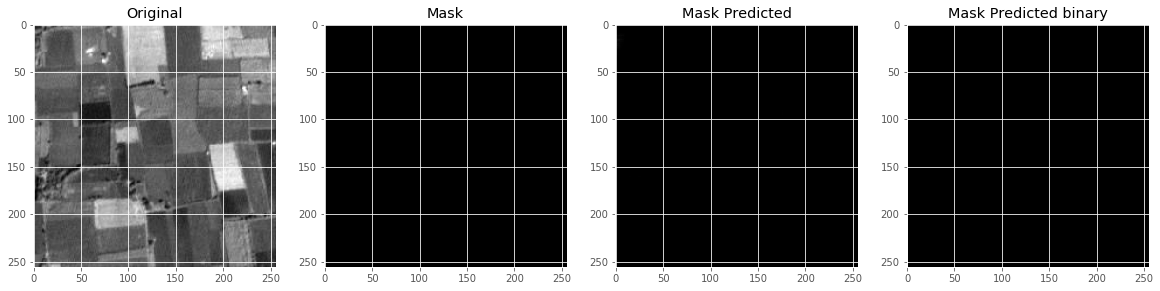

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

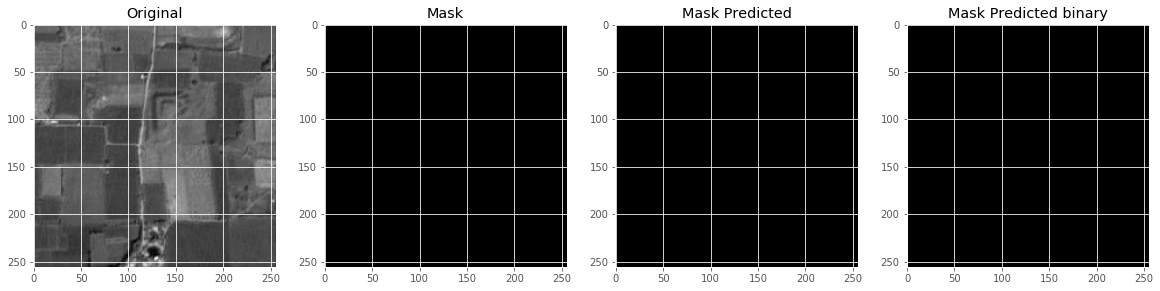

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

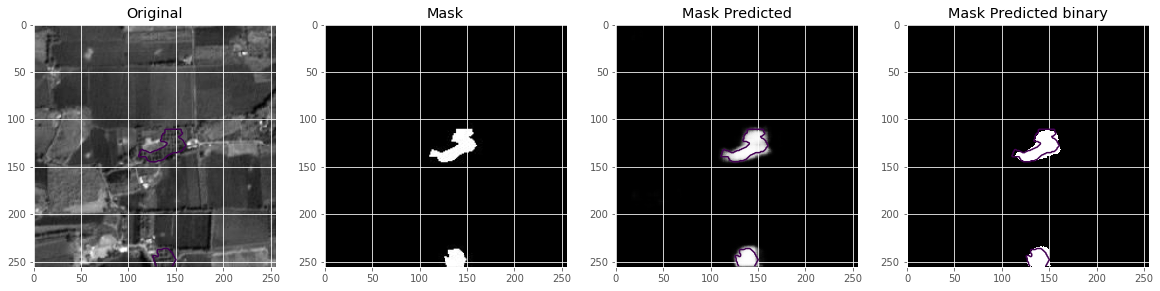

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

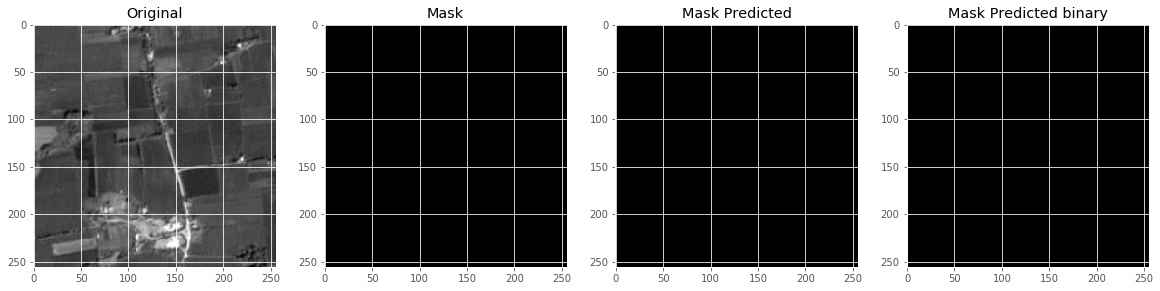

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

# Making the mosaic


In [9]:
model.load_weights('./Texture-segmentation/model-tgs-texture.h5')

NameError: ignored

In [0]:
ids = next(os.walk('./Texture-segmentation/samples_for_labeling/'))[2]
# ids = [i for i in ids if i.endswith('.jpg')]
print(len(ids))

In [10]:
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
  img = cv2.imread("./Texture-segmentation/samples_for_labeling/"+id_)
  name = id_.rstrip('.tif')
  name = name+'.jpg'
#   print(name)
  cv2.imwrite("./Texture-segmentation/samples_for_labeling/"+name,img)

In [11]:
ids = next(os.walk('./Texture-segmentation/samples_for_labeling/'))[2]
ids = [i for i in ids if i.endswith('.jpg')]
print(len(ids))

2376


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pwd

'/content'

In [0]:
# !rm -rf new_masks
# !mkdir ./drive/My\ Drive/new_masks
!mkdir ./new_masks

In [16]:
im_height = 256
im_width = 256

X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
masks=np.zeros((len(ids), 238, 221, 1), dtype = np.float32)

id_ = "1000.jpg"

# for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
#     print(id_)
img = load_img("./Texture-segmentation/samples_for_labeling/"+id_, grayscale=True)
x_img = img_to_array(img)
x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
X[n] = x_img/255.0
x = np.expand_dims(X[n],axis=0)
preds = model.predict(x)
# print(preds.shape)
pred_t = (preds > 0.5).astype(np.uint8)
pred_t = resize(pred_t,(1,238,221,1),mode='constant')
masks[n] = pred_t[0]
#   print(pred_t[0].shape)
#   plt.subplot(1,2,1)
#   plt.imshow(x_imgs.squeeze())
#   plt.subplot(1,2,2)
#   plt.imshow(pred_t[0].squeeze(),cmap='gray')
cv2.imwrite("./new_masks/"+id_,masks[n])
#   name = id_.rstrip('.jpg')
#   np.save("./drive/My Drive/new_masks/"+name,pred_t[0])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


True

In [0]:
!pip install pypng

     |████████████████████████████████| 296kB 23.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/a4/cd/54/c1d0803dfed5adf2bba530eda161581d9096d0154aee082cac
Successfully built pypng


In [0]:
import imageio
import scipy
import png

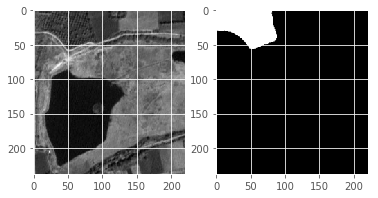

In [0]:
img = cv2.imread("./Texture-segmentation/samples_for_labeling/1000.jpg")
plt.subplot(1,2,1)
plt.imshow(img[:,:,0],cmap = "gray")
mask = np.load("./drive/My Drive/new_masks/1000.npy")
# print(img[:,:,0].shape)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0],cmap="gray")

(238, 221, 1)


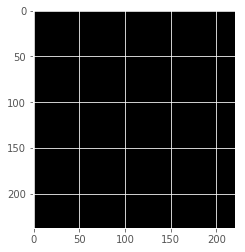

In [0]:
im  = np.load("./new_masks/1000.npy")
print(im.shape)
# imageio.imwrite("./new_masks/1000.jpg",im[:,:,0].astype(np.uint8))
png.from_array(im[:,:,0].astype(np.uint8),mode="L").save("x.png")
# scipy.misc.toimage(im[:,:,0].astype(np.uint8), cmin=0.0, cmax=...).save('outfile.jpg')
img = cv2.imread("./x.png")
# print(img.shape)
plt.imshow(img[:,:,0],cmap="gray")

In [0]:
# print(X[1].shape)

preds= model.predict(X, verbose=1)
pred_t = (preds > 0.5).astype(np.uint8)

2377/2377 [==============================] - 8s 3ms/step


In [0]:
print(preds.shape)

(2377, 256, 256, 1)


In [0]:
def plot_result(X, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('Original')


    ax[1].imshow(preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
#     ax[1].contour(y[ix].squeeze(), levels=[0.5])
    ax[1].set_title('Mask Predicted')
    
    ax[2].imshow(binary_preds[ix].squeeze(), cmap='gray', vmin=0, vmax=1)
#     ax[2].contour(y[ix].squeeze(), levels=[0.5])
    ax[2].set_title('Mask Predicted binary');

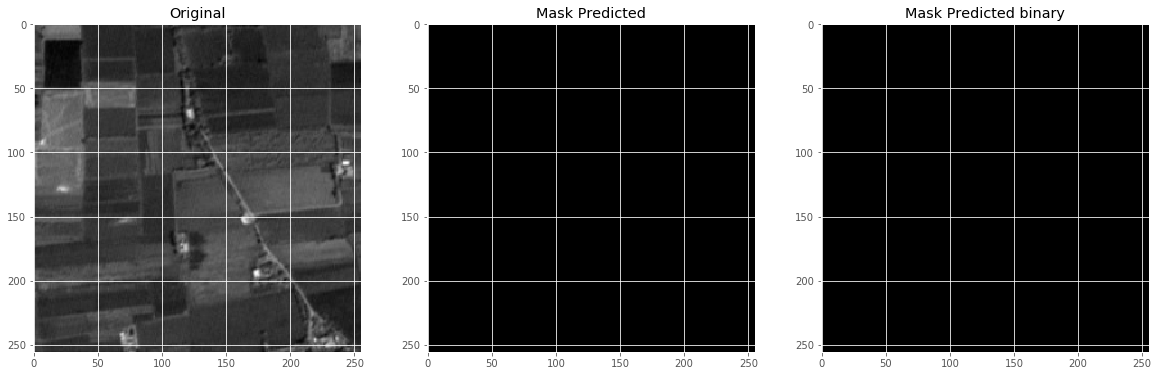

In [0]:
plot_result(X, preds, pred_t)